# US Front Month Historical Arb

This script uses the Spark API to plot the US Front Month Historical Arb across different via-points, as well as the most current forward curve.

This script uses elements from our API code samples. If you'd like a more basic and informative example of how to pull data via the Spark API, please visit our Github or API website:

- Github: https://github.com/spark-commodities/api-code-samples/blob/master/jupyter_notebooks/spark_api_netbacks.ipynb)
- API Website: https://www.sparkcommodities.com/api/code-examples/jupyter.html


### Have any questions?

If you have any questions regarding our API, or need help accessing specific datasets, please contact us at:

__data@sparkcommodities.com__

or refer to our API website for more information about this endpoint:
https://www.sparkcommodities.com/api/request/netbacks.html

## 1. Importing Data

Here we define the functions that allow us to retrieve the valid credentials to access the Spark API.

This section can remain unchanged for most Spark API users.

In [6]:
import json
import os
import sys
import numpy as np
from base64 import b64encode
from pprint import pprint
from urllib.parse import urljoin


try:
    from urllib import request, parse
    from urllib.error import HTTPError
except ImportError:
    raise RuntimeError("Python 3 required")


API_BASE_URL = "https://api.sparkcommodities.com"


def retrieve_credentials(file_path=None):
    """
    Find credentials either by reading the client_credentials file or reading
    environment variables
    """
    if file_path is None:

        client_id = os.getenv("SPARK_CLIENT_ID")
        client_secret = os.getenv("SPARK_CLIENT_SECRET")
        if not client_id or not client_secret:
            raise RuntimeError(
                "SPARK_CLIENT_ID and SPARK_CLIENT_SECRET environment vars required"
            )
    else:
        # Parse the file
        if not os.path.isfile(file_path):
            raise RuntimeError("The file {} doesn't exist".format(file_path))

        with open(file_path) as fp:
            lines = [l.replace("\n", "") for l in fp.readlines()]

        if lines[0] in ("clientId,clientSecret", "client_id,client_secret"):
            client_id, client_secret = lines[1].split(",")
        else:
            print("First line read: '{}'".format(lines[0]))
            raise RuntimeError(
                "The specified file {} doesn't look like to be a Spark API client "
                "credentials file".format(file_path)
            )

    print(">>>> Found credentials!")
    print(
        ">>>> Client_id={}, client_secret={}****".format(client_id, client_secret[:5])
    )

    return client_id, client_secret


def do_api_post_query(uri, body, headers):
    url = urljoin(API_BASE_URL, uri)

    data = json.dumps(body).encode("utf-8")

    # HTTP POST request
    req = request.Request(url, data=data, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 201, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def do_api_get_query(uri, access_token):
    url = urljoin(API_BASE_URL, uri)

    headers = {
        "Authorization": "Bearer {}".format(access_token),
        "Accept": "application/json",
    }

    # HTTP POST request
    req = request.Request(url, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 200, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def get_access_token(client_id, client_secret):
    """
    Get a new access_token. Access tokens are the thing that applications use to make
    API requests. Access tokens must be kept confidential in storage.

    # Procedure:

    Do a POST query with `grantType` and `scopes` in the body. A basic authorization
    HTTP header is required. The "Basic" HTTP authentication scheme is defined in
    RFC 7617, which transmits credentials as `clientId:clientSecret` pairs, encoded
    using base64.
    """

    # Note: for the sake of this example, we choose to use the Python urllib from the
    # standard lib. One should consider using https://requests.readthedocs.io/

    payload = "{}:{}".format(client_id, client_secret).encode()
    headers = {
        "Authorization": b64encode(payload).decode(),
        "Accept": "application/json",
        "Content-Type": "application/json",
    }
    body = {
        "grantType": "clientCredentials",
        "scopes": "read:netbacks,read:access,read:prices,read:routes"
    }

    content = do_api_post_query(uri="/oauth/token/", body=body, headers=headers)

    print(
        ">>>> Successfully fetched an access token {}****, valid {} seconds.".format(
            content["accessToken"][:5], content["expiresIn"]
        )
    )

    return content["accessToken"]


def list_netbacks(access_token):
    """
    Fetch available routes. Return contract ticker symbols

    # Procedure:

    Do a GET query to /v1.0/routes/ with a Bearer token authorization HTTP header.
    """
    content = do_api_get_query(uri="/v1.0/netbacks/reference-data/", access_token=access_token)

    print(">>>> All the routes you can fetch")
    tickers = []
    fobPort_names = []

    availablevia = []

    for contract in content["data"]['staticData']['fobPorts']:
        
        tickers.append(contract["uuid"])
        fobPort_names.append(contract['name'])
        
        availablevia.append(contract['availableViaPoints'])
    
    reldates = content["data"]['staticData']['sparkReleases']
        
    
    dicto1 = content["data"]
        
    return tickers, fobPort_names, availablevia, reldates, dicto1


## N.B. Credentials

Here we call the above functions, and input the file path to our credentials.

N.B. You must have downloaded your client credentials CSV file before proceeding. Please refer to the API documentation if you have not dowloaded them already.

The code then prints the available prices that are callable from the API, and their corresponding Python ticker names are displayed as a list at the bottom of the Output.

In [9]:
client_id, client_secret = retrieve_credentials(
    file_path="/tmp/client_credentials.csv"
)

# Authenticate:
access_token = get_access_token(client_id, client_secret)

# Fetch all contracts:
tickers, fobPort_names, availablevia, reldates, dicto1 = list_netbacks(access_token)


>>>> Found credentials!
>>>> Client_id=875f483b-19de-421a-8e9b-dceff6703e83, client_secret=6cdf8****
>>>> Successfully fetched an access token eyJhb****, valid 604799 seconds.
>>>> All the routes you can fetch


## Data Import Base Function

In [10]:
## Defining the function

def fetch_netback(access_token, ticker, release, via=None, laden=None, ballast=None):
    """
    For a route, fetch then display the route details

    # Procedure:

    Do GET queries to https://api.sparkcommodities.com/v1.0/routes/{route_uuid}/
    with a Bearer token authorization HTTP header.
    """
    
    query_params = "?fob-port={}".format(ticker)
    if release is not None:
        query_params += "&release-date={}".format(release)
    if via is not None:
        query_params += "&via-point={}".format(via)
    if laden is not None:
        query_params += "&laden-congestion-days={}".format(laden)
    if ballast is not None:
        query_params += "&ballast-congestion-days={}".format(ballast)

    
    content = do_api_get_query(
        uri="/v1.0/netbacks/{}".format(query_params),
        access_token=access_token,
    )
    
    my_dict = content['data']

    return my_dict


## Netbacks History Data Call

In [11]:
import time
import pandas as pd

def netbacks_history(tick, reldates, my_via=None, laden =None, ballast=None):

    months = []
    nea_outrights = []
    nea_ttfbasis = []
    nwe_outrights = []
    nwe_ttfbasis = []
    delta_outrights = []
    delta_ttfbasis = []
    release_date = []
    
    port = []

    for r in reldates:
        try:
            my_dict = fetch_netback(access_token, tickers[tick], release=r, via=my_via, laden=laden, ballast=ballast)
            
            m = my_dict['netbacks'][0]

            months.append(m['load']['month'])

            nea_outrights.append(float(m['nea']['outright']['usdPerMMBtu']))
            nea_ttfbasis.append(float(m['nea']['ttfBasis']['usdPerMMBtu']))

            nwe_outrights.append(float(m['nwe']['outright']['usdPerMMBtu']))
            nwe_ttfbasis.append(float(m['nwe']['ttfBasis']['usdPerMMBtu']))

            delta_outrights.append(float(m['neaMinusNwe']['outright']['usdPerMMBtu']))
            delta_ttfbasis.append(float(m['neaMinusNwe']['ttfBasis']['usdPerMMBtu']))

            release_date.append(my_dict['releaseDate'])
            port.append(fobPort_names[tick])
        except:
            print('Bad Date: ' + r)
        
        time.sleep(0.5)
        
    historical_df = pd.DataFrame({
                'Release Date': release_date,
                'FoB Port': port,
                'Month': months,
                'NEA Outrights': nea_outrights,
                'NEA TTF Basis': nea_ttfbasis,
                'NWE Outrights': nwe_outrights,
                'NWE TTF Basis': nwe_ttfbasis,
                'Delta Outrights': delta_outrights,
                'Delta TTF Basis': delta_ttfbasis,
                })
    

    historical_df['Release Date'] = pd.to_datetime(historical_df['Release Date'])
    
    return historical_df





# Calling data and Plotting

In [12]:

my_t = 'Sabine Pass'
t = fobPort_names.index(my_t)

my_rels = reldates[:200]

df_cogh = netbacks_history(t, my_rels, my_via='cogh')
df_suez = netbacks_history(t, my_rels, my_via='suez')
df_panama = netbacks_history(t, my_rels, my_via='panama')
df_panama_delays = netbacks_history(t, my_rels, my_via='panama', laden=7, ballast =7)

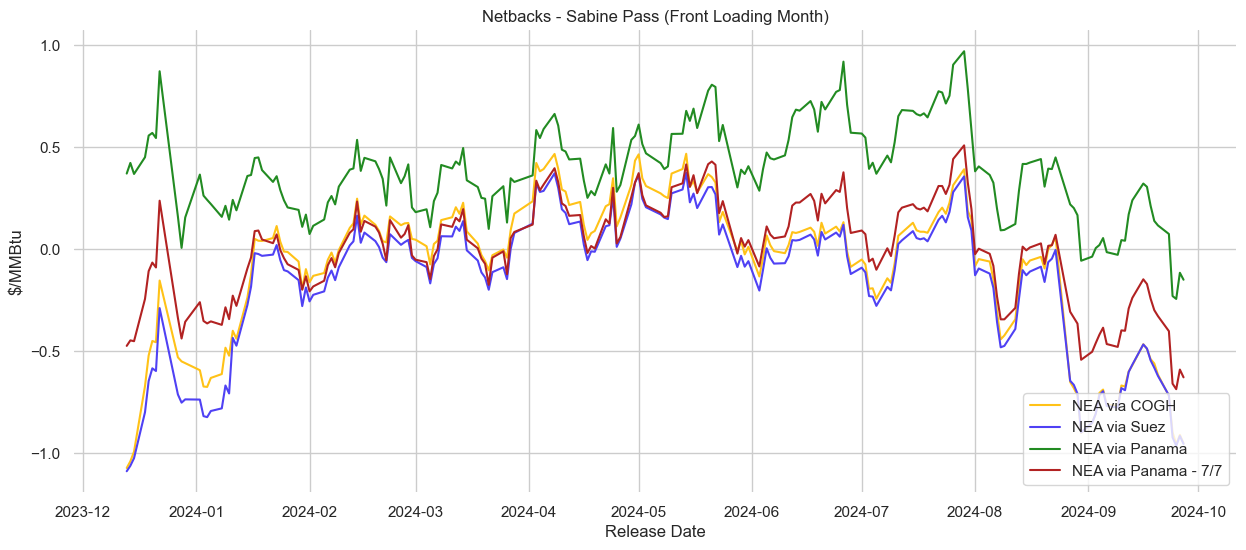

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_cogh['Release Date'], df_cogh['Delta Outrights'], color='#FFC217', label='NEA via COGH')
ax.plot(df_suez['Release Date'], df_suez['Delta Outrights'], color='#4F41F4', label='NEA via Suez')
ax.plot(df_panama['Release Date'], df_panama['Delta Outrights'], color='forestgreen', label='NEA via Panama')
ax.plot(df_panama_delays['Release Date'], df_panama_delays['Delta Outrights'], color='firebrick', label='NEA via Panama - 7/7')

ax.legend(loc=4)

plt.title('Netbacks - ' + df_cogh['FoB Port'].iloc[0] + ' (Front Loading Month)')
plt.ylabel('$/MMBtu')
plt.xlabel('Release Date')

sns.despine(left=True, bottom=True)

# Adding forward curves to plot

In [56]:
#function to call Fo curve and sort into dataframe

def netbacks(tick, my_via=None, my_release=reldates[0], laden=None, ballast=None):

    my_dict = fetch_netback(access_token, tickers[tick], release=my_release, via=my_via, laden=laden, ballast=ballast)
    
    route_name = my_dict['name']

    months = []
    nea_outrights = []
    nea_ttfbasis = []
    nwe_outrights = []
    nwe_ttfbasis = []
    delta_outrights = []
    delta_ttfbasis = []
    release_date = []
    
    port = []

    for m in my_dict['netbacks']:

        months.append(m['load']['month'])

        nea_outrights.append(float(m['nea']['outright']['usdPerMMBtu']))
        nea_ttfbasis.append(float(m['nea']['ttfBasis']['usdPerMMBtu']))

        nwe_outrights.append(float(m['nwe']['outright']['usdPerMMBtu']))
        nwe_ttfbasis.append(float(m['nwe']['ttfBasis']['usdPerMMBtu']))

        delta_outrights.append(float(m['neaMinusNwe']['outright']['usdPerMMBtu']))
        delta_ttfbasis.append(float(m['neaMinusNwe']['ttfBasis']['usdPerMMBtu']))
        
        release_date.append(my_release)
        port.append(fobPort_names[tick])
        
    historical_df = pd.DataFrame({
                'Release Date': release_date,
                'FoB Port': port,
                'Month': months,
                'NEA Outrights': nea_outrights,
                'NEA TTF Basis': nea_ttfbasis,
                'NWE Outrights': nwe_outrights,
                'NWE TTF Basis': nwe_ttfbasis,
                'Delta Outrights': delta_outrights,
                'Delta TTF Basis': delta_ttfbasis,
                })
    
    historical_df['Month'] = pd.to_datetime(historical_df['Month'])
    historical_df['Release Date'] = pd.to_datetime(historical_df['Release Date'])
    
    return historical_df



In [57]:
# Calling forward curves for each via point
fo_cogh = netbacks(t, my_via='cogh', my_release=reldates[0])
fo_suez = netbacks(t, my_via='suez', my_release=reldates[0])
fo_panama = netbacks(t, my_via='panama', my_release=reldates[0])

/v1.0/netbacks/?fob-port=c20695bb-306b-4ce5-a8f3-ef5d3769ea7a&release-date=2024-09-27&via-point=panama


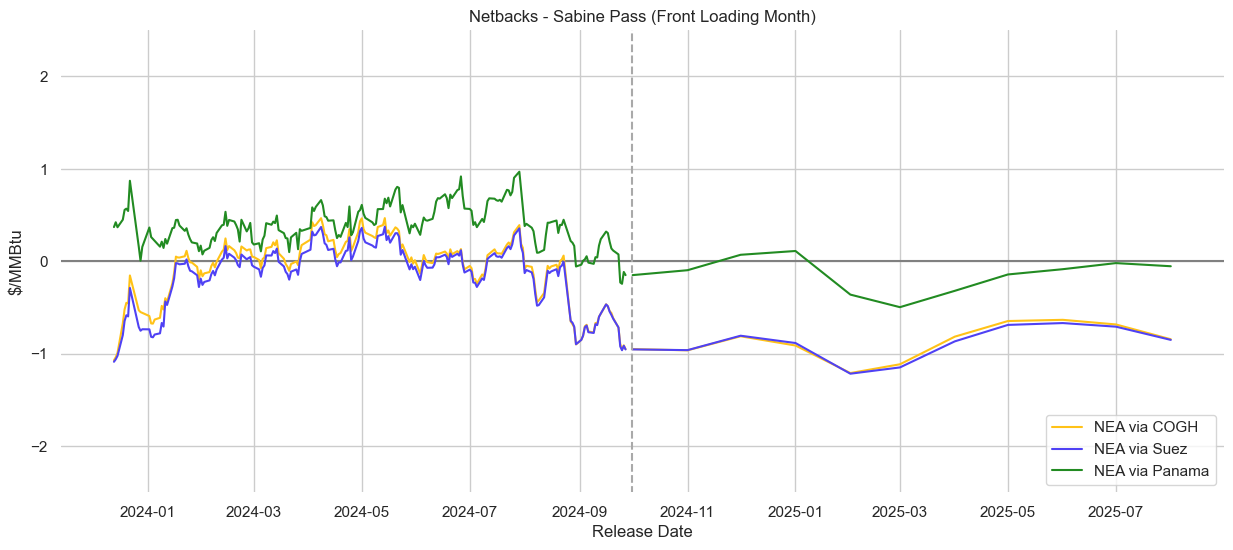

In [58]:
import datetime as dt

sns.set_theme(style="whitegrid")

fig9, ax9 = plt.subplots(figsize=(15,6))

plt.axhline(0, color='grey')

ax9.plot(df_cogh['Release Date'], df_cogh['Delta Outrights'], color='#FFC217', label='NEA via COGH')
ax9.plot(df_suez['Release Date'], df_suez['Delta Outrights'], color='#4F41F4', label='NEA via Suez')
ax9.plot(df_panama['Release Date'], df_panama['Delta Outrights'], color='forestgreen', label='NEA via Panama')

ax9.legend(loc=4)

ax9.plot(fo_cogh['Month'], fo_cogh['Delta Outrights'], color='#FFC217', label='NEA via COGH')
ax9.plot(fo_suez['Month'], fo_suez['Delta Outrights'], color='#4F41F4', label='NEA via Suez')
ax9.plot(fo_panama['Month'], fo_panama['Delta Outrights'], color='forestgreen', label='NEA via Panama')

ax9.plot([dt.datetime.today(), dt.datetime.today()],[-3,3], '--', color = 'darkgray')

plt.title('Netbacks - ' + df_cogh['FoB Port'].iloc[0] + ' (Front Loading Month)')
plt.ylabel('$/MMBtu')
plt.xlabel('Release Date')
plt.ylim(-2.5,2.5)



sns.despine(left=True, bottom=True)